In [47]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [18]:
data = pd.read_csv('/content/raw_house_data.csv')

In [19]:
print(data.head())

        MLS  sold_price  zipcode   longitude   latitude  lot_acres     taxes  \
0  21530491   5300000.0    85637 -110.378200  31.356362    2154.00   5272.00   
1  21529082   4200000.0    85646 -111.045371  31.594213    1707.00  10422.36   
2   3054672   4200000.0    85646 -111.040707  31.594844    1707.00  10482.00   
3  21919321   4500000.0    85646 -111.035925  31.645878     636.67   8418.58   
4  21306357   3411450.0    85750 -110.813768  32.285162       3.21  15393.00   

   year_built  bedrooms bathrooms sqrt_ft garage  \
0        1941        13        10   10500      0   
1        1997         2         2    7300      0   
2        1997         2         3    None   None   
3        1930         7         5    9019      4   
4        1995         4         6    6396      3   

                                    kitchen_features  fireplaces  \
0            Dishwasher, Freezer, Refrigerator, Oven         6.0   
1                       Dishwasher, Garbage Disposal         5.0   
2 

In [20]:
print(data.shape)

(5000, 16)


## Data is null start

In [21]:
# Check for missing values
missing_values = data.isnull().sum()

In [22]:
# Print the number of missing values for each column
print(missing_values)

MLS                  0
sold_price           0
zipcode              0
longitude            0
latitude             0
lot_acres           10
taxes                0
year_built           0
bedrooms             0
bathrooms            0
sqrt_ft              0
garage               0
kitchen_features     0
fireplaces          25
floor_covering       0
HOA                  0
dtype: int64


In [23]:
# Fill in missing values in lot_acres with the median
median_lot_acres = data['lot_acres'].median()
data['lot_acres'].fillna(median_lot_acres, inplace=True)

In [24]:
# Fill in missing values in fireplaces with the mode
mode_fireplaces = data['fireplaces'].mode()[0]
data['fireplaces'].fillna(mode_fireplaces, inplace=True)

In [45]:
# Verify that there are no more missing values
missing_values = data.isnull().sum()
print(missing_values)

MLS                 0
sold_price          0
zipcode             0
longitude           0
latitude            0
lot_acres           0
taxes               0
year_built          0
bedrooms            0
bathrooms           0
sqrt_ft             0
garage              0
kitchen_features    0
fireplaces          0
floor_covering      0
HOA                 0
dtype: int64


###Double verification

In [46]:
print(data.isnull().sum())

MLS                 0
sold_price          0
zipcode             0
longitude           0
latitude            0
lot_acres           0
taxes               0
year_built          0
bedrooms            0
bathrooms           0
sqrt_ft             0
garage              0
kitchen_features    0
fireplaces          0
floor_covering      0
HOA                 0
dtype: int64


##Data is null end

##Data types start

In [26]:
data.dtypes

MLS                   int64
sold_price          float64
zipcode               int64
longitude           float64
latitude            float64
lot_acres           float64
taxes               float64
year_built            int64
bedrooms              int64
bathrooms            object
sqrt_ft              object
garage               object
kitchen_features     object
fireplaces          float64
floor_covering       object
HOA                  object
dtype: object

In [27]:
non_numeric = data[pd.to_numeric(data['bathrooms'], errors='coerce').isna()]
print(non_numeric)

          MLS  sold_price  zipcode   longitude   latitude  lot_acres    taxes  \
2025  3044867    660000.0    85614 -110.969465  31.836723       3.60  5526.00   
2766  3042851    575000.0    85614 -110.960497  31.854446       0.87  4623.05   
3108  3047540    610000.0    85614 -111.002544  31.840061       1.70  3800.00   
3529  3046317    535000.0    85614 -110.986426  31.806614       4.27  3826.25   
3822  3045347    550000.0    85614 -111.008754  31.841141       0.99  3702.07   
4812  3046287    500000.0    85646 -111.051431  31.636207       1.03  8102.00   

      year_built  bedrooms bathrooms sqrt_ft garage  \
2025        2007         3      None    None      3   
2766        2002         3      None    None      3   
3108        2007         3      None    None      3   
3529        2006         2      None    None      3   
3822        2007         2      None    None      3   
4812        1999         4      None    None      2   

                                       kitchen

## Treating Bathroom data start

In [28]:
# Replace "None" with NaN
data['bathrooms'] = data['bathrooms'].replace("None", np.nan)

In [29]:
# Convert the 'bathrooms' column to float
data['bathrooms'] = data['bathrooms'].astype(float)

In [30]:
# Replace NaN with 0
data['bathrooms'] = data['bathrooms'].fillna(0)

In [31]:
# Round down to the nearest integer
data['bathrooms'] = data['bathrooms'].apply(lambda x: math.floor(x))

In [43]:
# Convert to int
data['bathrooms'] = data['bathrooms'].astype(int)

In [44]:
# Verify the result
print(data['bathrooms'].unique())

[10  2  3  5  6  4  8  7 15  1  9 11 18 14  0 35 36]


In [32]:
data.isna().sum()

MLS                 0
sold_price          0
zipcode             0
longitude           0
latitude            0
lot_acres           0
taxes               0
year_built          0
bedrooms            0
bathrooms           0
sqrt_ft             0
garage              0
kitchen_features    0
fireplaces          0
floor_covering      0
HOA                 0
dtype: int64

## Treating Bathroom data end

## Treating Garage data start

In [53]:
#Replace "None" with NaN
data['garage'] = data['garage'].replace("None", np.nan)

In [54]:
#Convert the columns to float
data['garage'] = data['garage'].astype(float)

In [55]:
#Replace NaN with 0
data['garage'] = data['garage'].fillna(0)

In [56]:
#Round down to the nearest integer
data['garage'] = data['garage'].apply(lambda x: math.floor(x))

In [57]:
#Convert to int
data['garage'] = data['garage'].astype(int)

##Treating Garage Data end

##Treating sqrt_ft data start

In [58]:
#Replace "None" with NaN
data['sqrt_ft'] = data['sqrt_ft'].replace("None", np.nan)

In [59]:
#Convert the columns to float
data['sqrt_ft'] = data['sqrt_ft'].astype(float)

In [60]:
#Replace NaN with 0
data['sqrt_ft'] = data['sqrt_ft'].fillna(0)

In [61]:
#Round down to the nearest integer
data['sqrt_ft'] = data['sqrt_ft'].apply(lambda x: math.floor(x))

In [62]:
#Convert to int
data['sqrt_ft'] = data['sqrt_ft'].astype(int)

##Treating sqrt_ft data end

## Data types end

#Data description and dupes start

In [33]:
data.describe()

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,fireplaces
count,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.00000,5000.000000,5000.000000,5000.000000
mean,2.127070e+07,7.746262e+05,85723.025600,-110.912107,32.308512,4.653974,9.402828e+03,1992.32800,3.933800,3.824200,1.880800
std,2.398508e+06,3.185556e+05,38.061712,0.120629,0.178028,51.633769,1.729385e+05,65.48614,1.245362,1.393156,1.135451
min,3.042851e+06,1.690000e+05,85118.000000,-112.520168,31.356362,0.000000,0.000000e+00,0.00000,1.000000,0.000000,0.000000
25%,2.140718e+07,5.850000e+05,85718.000000,-110.979260,32.277484,0.580000,4.803605e+03,1987.00000,3.000000,3.000000,1.000000
50%,2.161469e+07,6.750000e+05,85737.000000,-110.923420,32.318517,0.990000,6.223760e+03,1999.00000,4.000000,4.000000,2.000000
75%,2.180480e+07,8.350000e+05,85749.000000,-110.859078,32.394334,1.750000,8.082830e+03,2006.00000,4.000000,4.000000,3.000000
max,2.192856e+07,5.300000e+06,86323.000000,-109.454637,34.927884,2154.000000,1.221508e+07,2019.00000,36.000000,36.000000,9.000000


In [34]:
data.duplicated().sum()

0

#Data description and dupes end

#Check for outliers start

In [48]:
numerical_cols = ['sold_price', 'longitude', 'latitude', 'lot_acres', 'taxes', 'year_built', 'bedrooms', 'bathrooms', 'sqrt_ft', 'garage', 'fireplaces', 'HOA']

TypeError: ignored

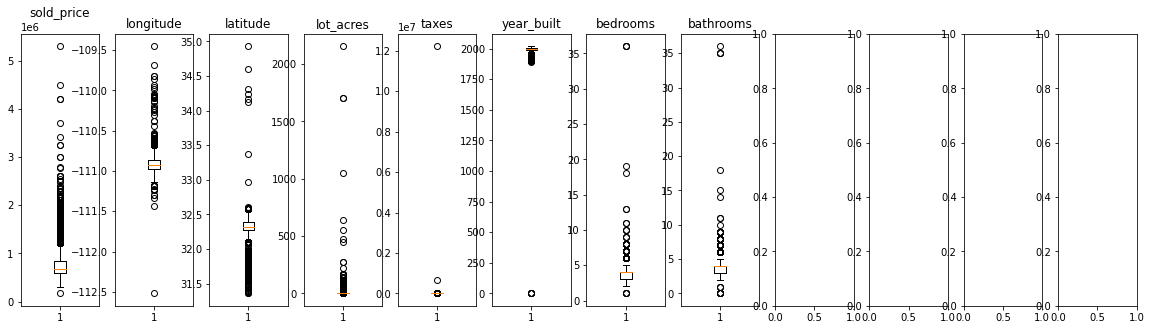

In [51]:
fig, axs = plt.subplots(ncols=len(numerical_cols), figsize=(20,5))
for i, col in enumerate(numerical_cols):
  axs[i].boxplot(data[col])
  axs[i].set_title(col)

plt.show()

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MLS               5000 non-null   int64  
 1   sold_price        5000 non-null   float64
 2   zipcode           5000 non-null   int64  
 3   longitude         5000 non-null   float64
 4   latitude          5000 non-null   float64
 5   lot_acres         5000 non-null   float64
 6   taxes             5000 non-null   float64
 7   year_built        5000 non-null   int64  
 8   bedrooms          5000 non-null   int64  
 9   bathrooms         5000 non-null   int64  
 10  sqrt_ft           5000 non-null   object 
 11  garage            5000 non-null   object 
 12  kitchen_features  5000 non-null   object 
 13  fireplaces        5000 non-null   float64
 14  floor_covering    5000 non-null   object 
 15  HOA               5000 non-null   object 
dtypes: float64(6), int64(5), object(5)
memory 

#Check for outliers end

#Class example

In [35]:
from geopy import Nominatim

Give it user location

In [36]:
geolocator = Nominatim(user_agent = 'mAIstros')

variable name we are giving it

In [37]:
location = geolocator.geocode("1785 The Exchange SE, Atlanta")

Let's look at the location

In [38]:
location

Location(1785, The Exchange Southeast, Atlanta, Cobb County, Georgia, 30339, United States, (33.90915665, -84.47914869915438, 0.0))

look at the point

In [39]:
location.point

Point(33.90915665, -84.47914869915438, 0.0)

In [40]:
location = geolocator.geocode("10 Downing Street")

In [41]:
location

Location(10 Downing Street, 10, Downing Street, Westminster, Covent Garden, London, Greater London, England, SW1A 2AA, United Kingdom, (51.5034927, -0.12770540128798905, 0.0))

calc location point

In [42]:
a + b = c

SyntaxError: ignored